In [1]:
import pysixtracklib as pyst
from pysixtracklib import stcommon as st

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import ctypes

In [4]:
import PyHEADTAIL_concept

In [5]:
from scipy.constants import e, c, m_p

In [6]:
pyht_beam = PyHEADTAIL_concept.beam

In [7]:
num_particles = PyHEADTAIL_concept.beam.macroparticlenumber

In [8]:
pyst_beam = pyst.Particles.from_ref(num_particles=num_particles, p0c=pyht_beam.p0 * c / e)

`pyst_beam` is on the CPU now

# Preparing PyHEADTAIL_concept to talk to pystl

In [9]:
import cupy

from cupy.cuda.memory import UnownedMemory, MemoryPointer

In [10]:
def convolve_via_fft(a, b):
    if len(b) < len(a):
        a, b = b, a
    a_padded = pm.zeros(len(b), dtype=np.float64)
    # rolled by 1 in order to reproduce np.convolve(mode='valid'):
    a_padded[-len(a)+1:] = a[:-1]
    a_padded[0] = a[-1] 
    f1 = pm.fft(a_padded)
    f2 = pm.fft(b)
    conv = pm.ifft(f1 * f2)
    conv = pm.real(conv) # throw away imaginary part (numerical fluctuations around 0)
    return conv[:len(a)]

pm = PyHEADTAIL_concept.pm

# references to all relevant methods on GPU via cupy
cupy_dict = dict(
    sin=cupy.sin,
    cos=cupy.cos,
    tan=cupy.tan,
    exp=cupy.exp,
    sinh=cupy.sinh,
    cosh=cupy.cosh,
    tanh=cupy.tanh,
    sqrt=cupy.sqrt,
    abs=cupy.abs,
    floor=cupy.floor,
    real=cupy.real,
    imag=cupy.imag,
    fft=cupy.fft.fft,
    ifft=cupy.fft.ifft,
    # voila:
    convolve=convolve_via_fft,
    
    histogram=cupy.histogram,
    mean=cupy.mean,
    cov=lambda a, b: cupy.cov(a, b)[0, 1],
    std=lambda u: cupy.sqrt(cupy_dict['cov'](u, u)),
    emittance_geo=lambda u, up: cupy.sqrt(cupy.linalg.det(cupy.cov(u, up))),
    asarray=cupy.asarray,
    empty=cupy.empty,
    zeros=cupy.zeros,
    linspace=cupy.linspace,
    arange=cupy.arange,
    take=cupy.take,
    where=cupy.where,
    concatenate=cupy.concatenate,
    clip=cupy.clip,
)

class GPU_cupy(object):
    '''GPU context manager working with the cupy library.
    '''
    
    def __init__(self, beam):
        self.beam = beam
        self.to_move = beam.coords_n_momenta

    def __enter__(self):
        # moving data to device
        for attr in self.to_move:
            coord = getattr(self.beam, attr)
            transferred = cupy.asarray(coord)
            setattr(self.beam, attr, transferred)

        # replace functions in general.math.py
        pm.update_active_dict(cupy_dict)
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        # moving data back to host
        for attr in self.to_move:
            coord = getattr(self.beam, attr)
            transferred = coord.get()
            setattr(self.beam, attr, transferred)
        pm.update_active_dict(pm._default_function_dict)

In [11]:
def provide_cupy_array(ptr, owner): # tie owner to particles instead of particles_addr
    mem = UnownedMemory(ptr=ptr, size=num_particles, owner=owner)#, device_id=device_id)
    memptr = MemoryPointer(mem, offset=0)
    return cupy.ndarray(num_particles, dtype=float, memptr=memptr)

# version A.) rocknrolling the new stuff

In [12]:
elements = pyst.Elements()
elements.Drift(length=1.2)
elements.Multipole(knl=[0, 1e-3]);

In [13]:
trackjob = pyst.CudaTrackJob(elements, pyst_beam)

In [14]:
trackjob.fetch_particle_addresses()
assert trackjob.last_status_success

In [15]:
ptr = trackjob.get_particle_addresses() # particleset==0 is default

In [17]:
x = provide_cupy_array(ptr.contents.x, owner=trackjob)
px = provide_cupy_array(ptr.contents.px, owner=trackjob)
y = provide_cupy_array(ptr.contents.y, owner=trackjob)
py = provide_cupy_array(ptr.contents.py, owner=trackjob)
z = provide_cupy_array(ptr.contents.zeta, owner=trackjob)
delta = provide_cupy_array(ptr.contents.delta, owner=trackjob)

$\implies$ we got the pointers, yay!

In [18]:
with GPU_cupy(pyht_beam):
    x[:] = pyht_beam.x
    px[:] = 1 * pyht_beam.xp
    y[:] = pyht_beam.y
    py[:] = 1 * pyht_beam.yp
    z[:] = pyht_beam.z
    delta[:] = pyht_beam.dp

In [19]:
class TrackSixTrackLib(PyHEADTAIL_concept.Element):
    def __init__(self, trackjob, i_start, i_end):
        self.trackjob = trackjob
        
        self.i_start = i_start
        self.i_end = i_end
        n_elements = len(elements.get_elements())
        self.is_last_element = i_end == n_elements

    def track(self, beam):
        # pass arrays and convert units
        self.pyht_to_stlib(beam)
        # track in SixTrackLib
        trackjob.track_line(self.i_start, self.i_end, 
                            finish_turn=self.is_last_element)
        assert trackjob.last_track_status_success
        # pass arrays back (converting units back)
        self.stlib_to_pyht(beam)

    def pyht_to_stlib(self, beam):
        x[:] = beam.x
        px[:] = 1 * beam.xp
        y[:] = beam.y
        py[:] = 1 * beam.yp
        z[:] = beam.z
        delta[:] = beam.dp

    def stlib_to_pyht(self, beam):
        beam.x = x
        beam.xp = 1 * px
        beam.y = y
        beam.yp = 1 * py
        beam.z = z
        beam.dp = delta

In [20]:
elem_first = TrackSixTrackLib(elements, 0, 1)
elem_second = TrackSixTrackLib(elements, 1, 2)

In [21]:
beam = pyht_beam

In [22]:
one_turn_map_mixed = [
    elem_first, PyHEADTAIL_concept.resonator, elem_second] #PyHEADTAIL_concept.RFSystem, 

In [23]:
n_turns = 100

mean_x = np.empty(n_turns, dtype=float)
mean_y = np.empty_like(mean_x)
mean_z = np.empty_like(mean_x)

with GPU_cupy(beam):
    # TRACKING!
    for turn in range(n_turns):
        for el in one_turn_map_mixed:
            el.track(beam)
            mean_x[turn] = beam.mean_x().get()
            mean_y[turn] = beam.mean_y().get()
            mean_z[turn] = beam.mean_z().get()

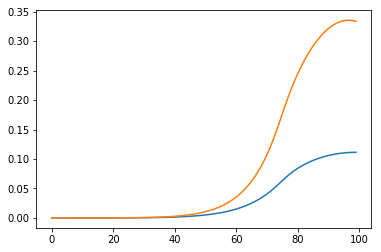

In [24]:
plt.plot(mean_x)
plt.plot(mean_y)

$\implies$ it runs like a .. butterfly! yay

.

.

.

.

.

# version B.) Old stuff via low-level C stuff exposed in python

In [25]:
ctx = st.st_CudaContext_create()

AttributeError: module 'pysixtracklib.stcommon' has no attribute 'st_CudaContext_create'

In [9]:
# creating particles buffer itself
particles_arg = st.st_CudaArgument_new(ctx)
ptr_buffer = st.st_Buffer_new_mapped_on_cbuffer(pyst_beam._buffer)
assert (st.st_CudaArgument_send_buffer(particles_arg, ptr_buffer),
        "could not remap particles on GPU")

<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-9-62f10bde8789>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (st.st_CudaArgument_send_buffer(particles_arg, ptr_buffer),


In [10]:
# creating particles with pointers to actual array contents in particles
particles_addr = st.st_ParticlesAddr()
sizeof_particles_addr = ctypes.c_uint64(ctypes.sizeof(particles_addr))
ptr_particles_addr = st.st_ParticlesAddr_preset(ctypes.byref(particles_addr))

particles_addr_arg = st.st_CudaArgument_new(ctx)
assert st.st_CudaArgument_send_memory(particles_addr_arg, ptr_particles_addr, sizeof_particles_addr)

In [11]:
# 
st.st_Particles_extract_addresses_cuda(
    st.st_CudaArgument_get_arg_buffer(particles_addr_arg),
    st.st_CudaArgument_get_arg_buffer(particles_arg)
)

0

In [12]:
st.st_CudaArgument_receive_memory(particles_addr_arg, ptr_particles_addr, sizeof_particles_addr)

True

In [13]:
ptr_x, ptr_px, ptr_y, ptr_py, ptr_z, ptr_delta = (
    particles_addr.x, particles_addr.px, 
    particles_addr.y, particles_addr.py, 
    particles_addr.zeta, particles_addr.delta)

$\implies$ we got the pointers

In [17]:
x = provide_cupy_array(ptr_x)
px = provide_cupy_array(ptr_px)
y = provide_cupy_array(ptr_y)
py = provide_cupy_array(ptr_py)
z = provide_cupy_array(ptr_z)
delta = provide_cupy_array(ptr_delta)

In [26]:
with GPU_cupy(pyht_beam):
    x[:] = pyht_beam.x
    px[:] = 1 * pyht_beam.xp
    y[:] = pyht_beam.y
    py[:] = 1 * pyht_beam.yp
    z[:] = pyht_beam.z
    delta[:] = pyht_beam.dp

$\implies$ done! can talk between both codes :)

# let's go for a lattice

In [35]:
import numpy as np

In [33]:
def idivup(a, b):
    ''' Compute int(a)//int(b) and round up to next integer if a%b != 0 '''
    a = np.int32(a)
    b = np.int32(b)
    z = (a // b + 1) if (a % b != 0) else (a // b)
    return int(z)

In [29]:
elements = pyst.Elements()
elements.Drift(length=1.2)
elements.Multipole(knl=[0, 1e-3]);

In [30]:
lattice = st.st_Buffer_new_mapped_on_cbuffer(elements.cbuffer)
lattice_arg = st.st_CudaArgument_new(ctx)
assert st.st_CudaArgument_send_buffer(lattice_arg, lattice), 'could not transfer lattice to GPU'

In [53]:
class TrackSixTrackLib(PyHEADTAIL_concept.Element):
    def __init__(self, elements, i_start, i_end):
        self.elements = elements
        self.i_start = ctypes.c_uint64(i_start)
        self.i_end = ctypes.c_uint64(i_end)
        n_elements = len(elements.get_elements())
        self.is_last_element = i_end == n_elements

    def track(self, beam):
        # pass arrays and convert units
        self.pyht_to_stlib(beam)
        # track in SixTrackLib
        st.st_Track_particles_line_cuda_on_grid(
            st.st_CudaArgument_get_arg_buffer(particles_arg),
            st.st_CudaArgument_get_arg_buffer(lattice_arg),
            self.i_start, self.i_end, ctypes.c_bool(self.is_last_element),
            # cuda grid / block definition:
            idivup(num_particles, 256), 256,
        )
        # pass arrays back (converting units back)
        self.stlib_to_pyht(beam)

    def pyht_to_stlib(self, beam):
        x[:] = beam.x
        px[:] = 1 * beam.xp
        y[:] = beam.y
        py[:] = 1 * beam.yp
        z[:] = beam.z
        delta[:] = beam.dp

    def stlib_to_pyht(self, beam):
        beam.x = x
        beam.xp = 1 * px
        beam.y = y
        beam.yp = 1 * py
        beam.z = z
        beam.dp = delta

$\implies$ still missing unit conversion between both codes

# ready to track!

In [54]:
elem_first = TrackSixTrackLib(elements, 0, 1)
elem_second = TrackSixTrackLib(elements, 1, 2)

In [55]:
x0 = pyht_beam.x.copy()
with GPU_cupy(pyht_beam):
    elem_first.track(pyht_beam)
pyht_beam.x - x0

array([-1.56343739e-03,  3.32485712e-04,  9.53883792e-05, ...,
        9.88028777e-04,  6.43043835e-04, -3.81919196e-04])

# track more advanced with both codes:

In [59]:
beam = pyht_beam

In [64]:
one_turn_map_mixed = [
    elem_first, PyHEADTAIL_concept.resonator, elem_second] #PyHEADTAIL_concept.RFSystem, 

In [65]:
n_turns = 100

mean_x = np.empty(n_turns, dtype=float)
mean_y = np.empty_like(mean_x)
mean_z = np.empty_like(mean_x)

with GPU_cupy(beam):
    # TRACKING!
    for turn in range(n_turns):
        for el in one_turn_map_mixed:
            el.track(beam)
            mean_x[turn] = beam.mean_x().get()
            mean_y[turn] = beam.mean_y().get()
            mean_z[turn] = beam.mean_z().get()